---
title: Information Sources Network Analysis
jupyter: python3
format: html
theme: flatly
toc: true
code-fold: true
execute:
  echo: false
  warning: false
  message: false
---

Imagine a world where the only information you received came from your local community. Anything beyond it would take days, weeks, or might never reach you at all. Contrast that with today, where global news is instantly available across countless channels and formats.

If you like to read, you can choose from blogs, magazines, journals, newspapers, and social media. If you prefer visuals, there’s television, YouTube, and short-form video. If you prefer listening while commuting or multitasking, there’s radio and podcasts. With such variety, it feels like there’s no excuse for being uninformed.

But when we step back and look at information as a network, one question becomes central: which sources are mentioned most often as providers of news? Are newspapers still cited more frequently? Do television stations dominate? Or are online platforms emerging as the most prevalent sources?

That’s what we aim to uncover by exploring our information network datasets.

In [1]:
import sys
print(sys.executable)
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sn

c:\Users\darwh\anaconda33\python.exe


## Data exploration

In [2]:
nodes_df = pd.read_csv("InputFileNodes.csv")
edges_df = pd.read_csv("InputFileEdges.csv")
# Explore the shapes and first few rows of the dataframes
print("Nodes DataFrame shape:", nodes_df.shape)
print("Nodes DataFrame head:")
print(nodes_df.head())

print("\nEdges DataFrame shape:", edges_df.shape)
print("Edges DataFrame head:")
print(edges_df.head())

Nodes DataFrame shape: (17, 5)
Nodes DataFrame head:
    id                media  media.type type.label  audience.size
0  s01             NY Times           1  Newspaper             20
1  s02      Washington Post           1  Newspaper             25
2  s03  Wall Street Journal           1  Newspaper             30
3  s04            USA Today           1  Newspaper             32
4  s05             LA Times           1  Newspaper             20

Edges DataFrame shape: (51, 4)
Edges DataFrame head:
  from   to  weight       type
0  s01  s02      10  hyperlink
1  s01  s02      12  hyperlink
2  s01  s03      22  hyperlink
3  s01  s04      21  hyperlink
4  s04  s11      22    mention


So, as we can see, the nodes dataframe provides details about news sources, including their media type and audience size. The edges dataframe contains directed connections between sources, with weights indicating the strength of the relationship and the type of reference (such as a hyperlink or mention). Lets create our network.

In [3]:
G = nx.from_pandas_edgelist(
    edges_df,
    source='from',
    target='to',
    edge_attr=['weight', 'type'],
    create_using=nx.DiGraph()
)

# Add node attributes from nodes_df
for idx, row in nodes_df.iterrows():
    G.nodes[row['id']].update(row.to_dict())

print("Directed network created.")
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

Directed network created.
Number of nodes: 17
Number of edges: 48


In [4]:
# Map media.type to colors
import matplotlib.patches as mpatches


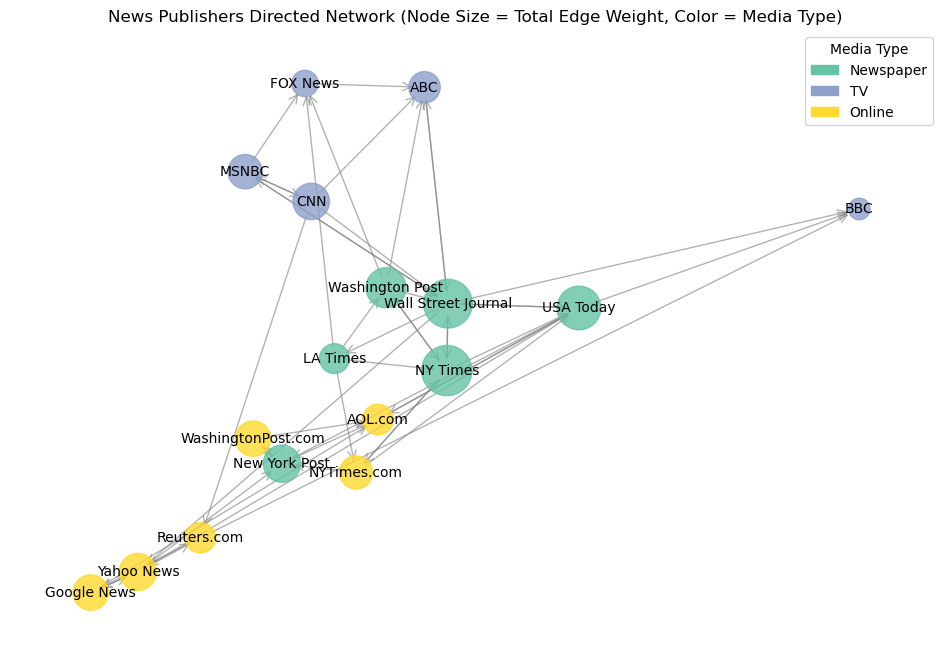

In [5]:
# Calculate node size as total weight of incoming and outgoing edges
node_weights = {}
for node in G.nodes:
    in_weight = sum([d.get('weight', 1) for _, _, d in G.in_edges(node, data=True)])
    out_weight = sum([d.get('weight', 1) for _, _, d in G.out_edges(node, data=True)])
    node_weights[node] = in_weight + out_weight

node_sizes = [node_weights[n] * 10 for n in G.nodes]  # Scale for visualization


media_labels = list(nodes_df['type.label'].unique())
color_map = {label: plt.cm.Set2(i / len(media_labels)) for i, label in enumerate(media_labels)}
node_colors = [color_map[G.nodes[n].get('type.label', media_labels[0])] for n in G.nodes]

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.8)
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=15, edge_color='gray', alpha=0.6)

labels = {n: G.nodes[n].get('media', n) for n in G.nodes}
nx.draw_networkx_labels(G, pos, labels, font_size=10)

legend_handles = [mpatches.Patch(color=color_map[label], label=str(label)) for label in media_labels]
plt.legend(handles=legend_handles, title="Media Type", loc="best")

plt.title("News Publishers Directed Network (Node Size = Total Edge Weight, Color = Media Type)")
plt.axis('off')
plt.show()

# Centralities

We can try understand how central a source is by how of often other nodes refrence it, to do this we can calculate diffrent centralites.

| Metric | Layman's Definition |
|----|----|
| Degree Centrality | How many direct connections a source has to others (both incoming and outgoing). |
| In-Degree Centrality | How often a source is referenced or cited by others. |
| Out-Degree Centrality | How often a source references or cites other sources. |
| Betweenness Centrality | How often a source acts as a bridge connecting other sources in the network. |
| Closeness Centrality | How quickly a source can reach all other sources in the network (lower distance means higher value). |

In [6]:
# Calculate centrality measures for each node
degree_centrality = nx.degree_centrality(G)
in_degree_centrality = nx.in_degree_centrality(G)
out_degree_centrality = nx.out_degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)

# Create a DataFrame to display centrality measures
centrality_df = pd.DataFrame({
    'media': [G.nodes[n].get('media', n) for n in G.nodes],
    'type.label': [G.nodes[n].get('type.label', '') for n in G.nodes],
    'degree_centrality': [degree_centrality[n] for n in G.nodes],
    'in_degree_centrality': [in_degree_centrality[n] for n in G.nodes],
    'out_degree_centrality': [out_degree_centrality[n] for n in G.nodes],
    'betweenness_centrality': [betweenness_centrality[n] for n in G.nodes],
    'closeness_centrality': [closeness_centrality[n] for n in G.nodes]
})

print(centrality_df.sort_values('degree_centrality', ascending= False).head(10))

                  media type.label  degree_centrality  in_degree_centrality  \
2   Wall Street Journal  Newspaper             0.8125                0.3750   
3             USA Today  Newspaper             0.5625                0.2500   
0              NY Times  Newspaper             0.5000                0.2500   
14           Yahoo News     Online             0.3750                0.1875   
7         New York Post  Newspaper             0.3750                0.2500   
1       Washington Post  Newspaper             0.3750                0.1250   
9                 MSNBC         TV             0.3125                0.1250   
13                  CNN         TV             0.3125                0.0625   
12                  ABC         TV             0.3125                0.2500   
8               AOL.com     Online             0.3125                0.2500   

    out_degree_centrality  betweenness_centrality  closeness_centrality  
2                  0.4375                0.529167       

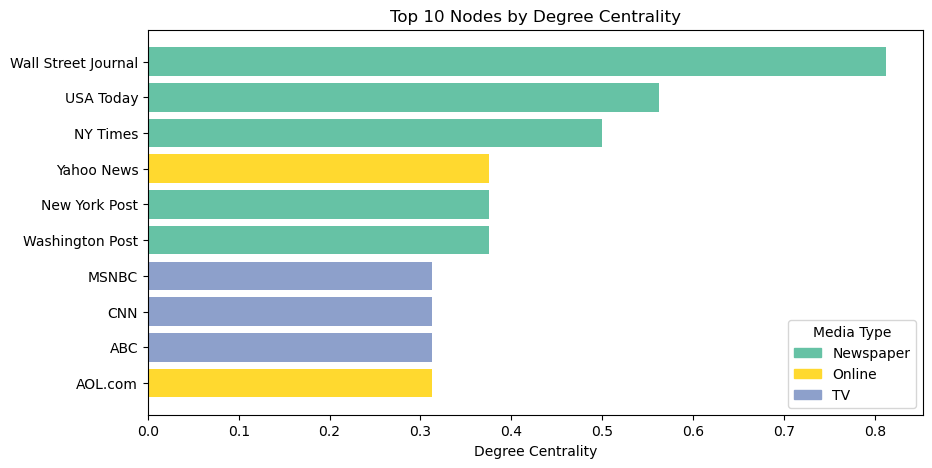

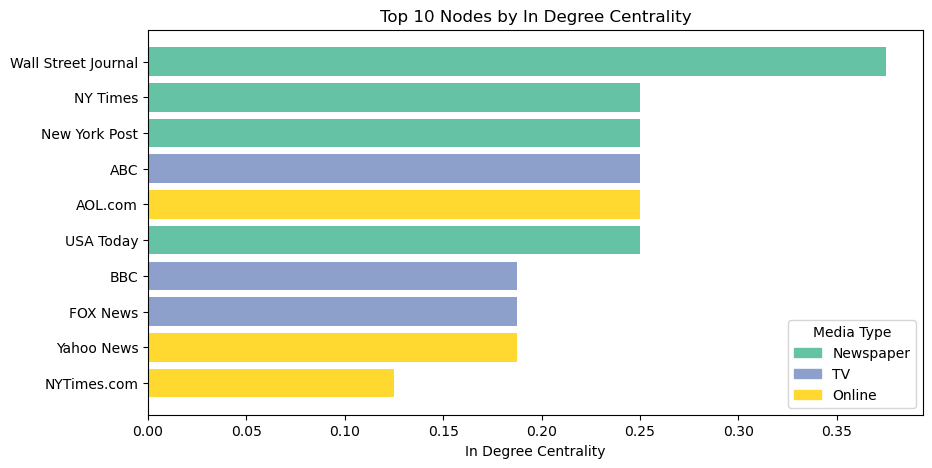

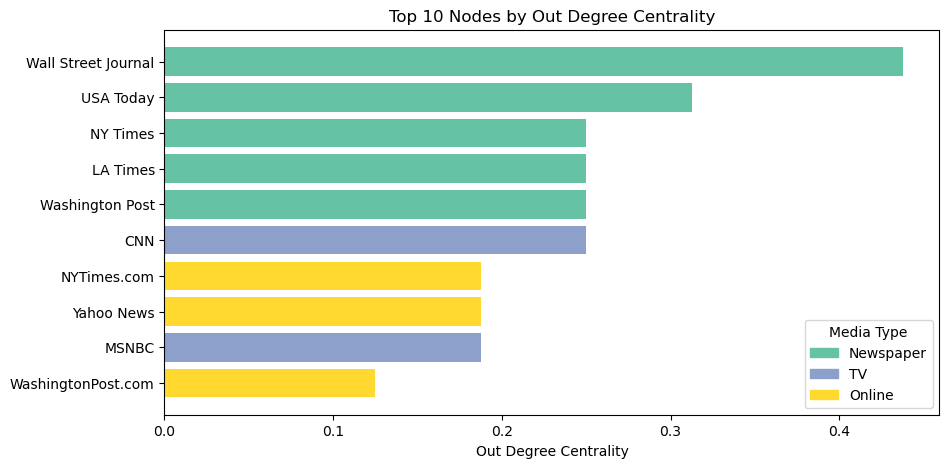

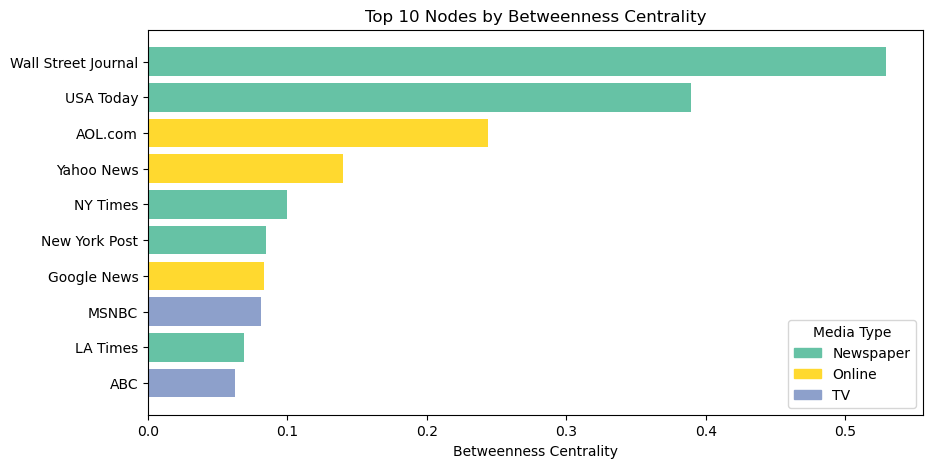

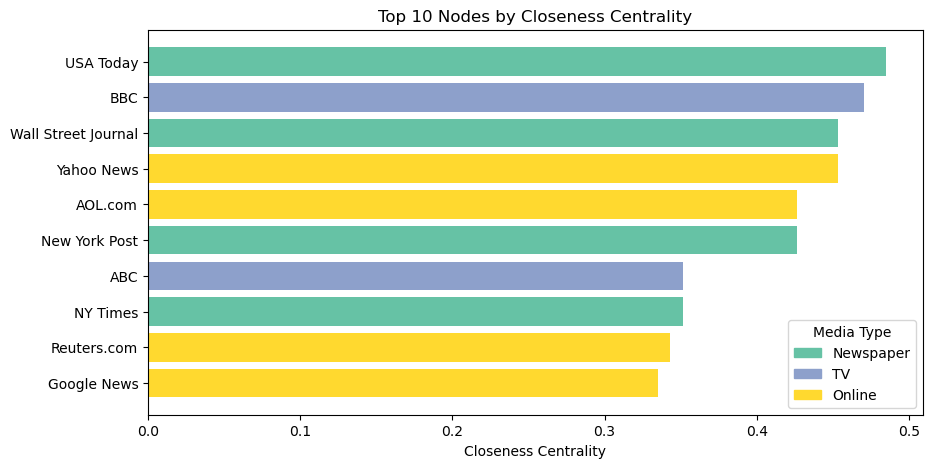

In [7]:
# Plot top 10 nodes for each centrality metric

metrics = [
    'degree_centrality',
    'in_degree_centrality',
    'out_degree_centrality',
    'betweenness_centrality',
    'closeness_centrality'
]

for metric in metrics:
    top10 = centrality_df.sort_values(metric, ascending=False).head(10)
    plt.figure(figsize=(10, 5))
    colors = top10['type.label'].map(lambda x: color_map.get(x, 'gray'))
    plt.barh(top10['media'], top10[metric], color=colors)
    plt.xlabel(metric.replace('_', ' ').title())
    plt.title(f"Top 10 Nodes by {metric.replace('_', ' ').title()}")
    plt.gca().invert_yaxis()
    # Add legend for media type colors
    legend_handles = [mpatches.Patch(color=color_map[label], label=str(label)) for label in top10['type.label'].unique()]
    plt.legend(handles=legend_handles, title="Media Type", loc="best")
    plt.show()

As we can see there is top spot in the dataset is always claimed by a news paper for centality meausres but we see online resources also well represented especially for betweeness centrality lets look at aggregats for the entire network.

Average centrality measures by media type:
            degree_centrality  in_degree_centrality  out_degree_centrality  \
type.label                                                                   
Newspaper            0.489583              0.218750               0.270833   
Online               0.281250              0.145833               0.135417   
TV                   0.275000              0.162500               0.112500   

            betweenness_centrality  closeness_centrality  
type.label                                                
Newspaper                 0.199421              0.383529  
Online                    0.084491              0.353684  
TV                        0.030972              0.334240  


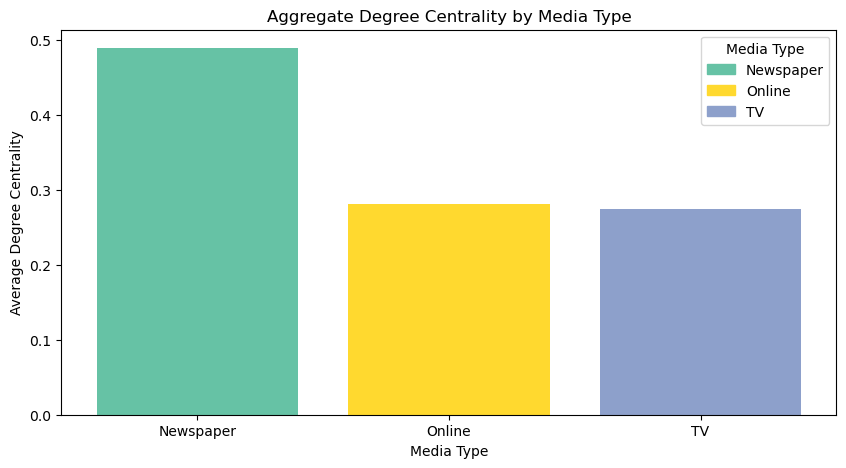

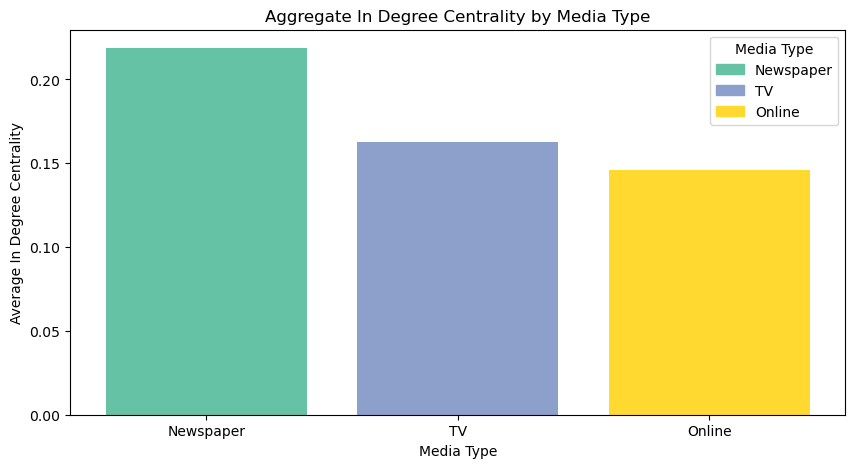

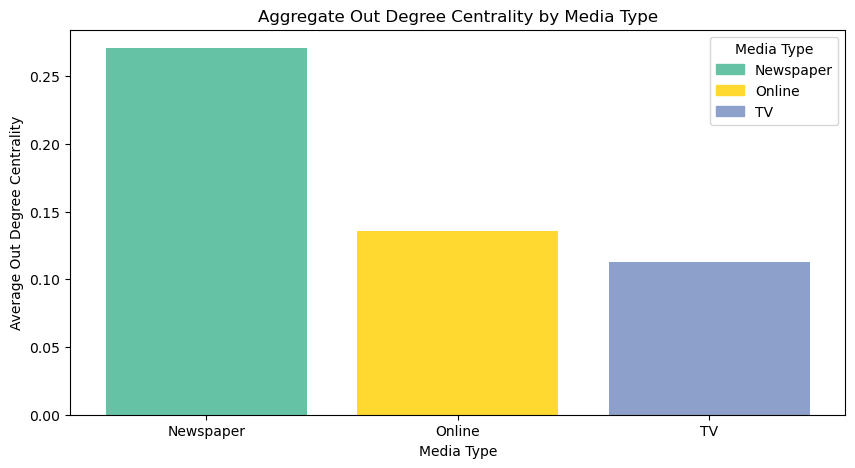

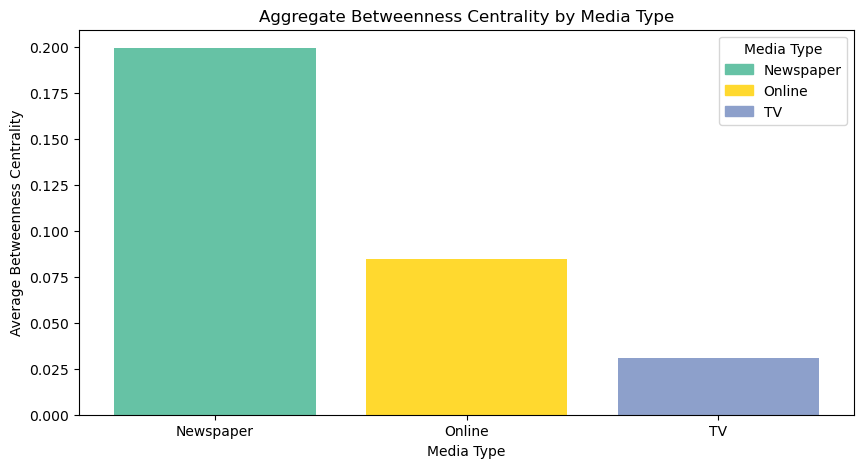

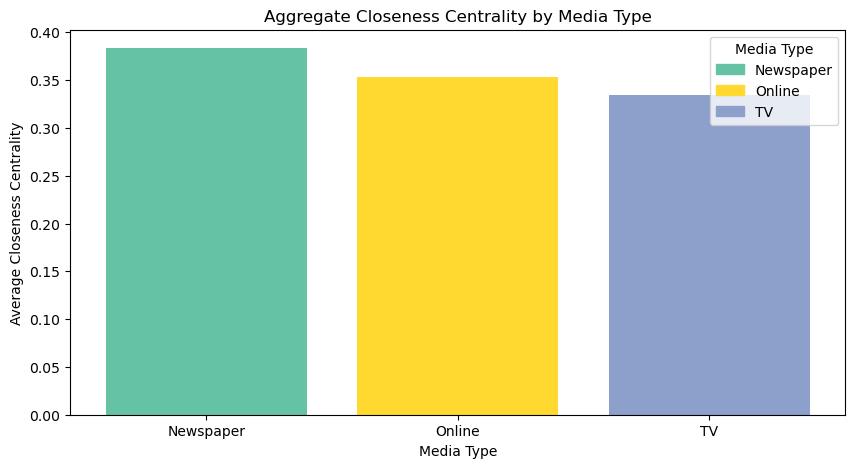

In [8]:
# Aggregate centrality measures by media type and display
centrality_by_type = centrality_df.groupby('type.label').mean(numeric_only=True)
print("Average centrality measures by media type:")
print(centrality_by_type)

# Optional: plot the aggregated centrality measures for each media type
metrics = [
    'degree_centrality',
    'in_degree_centrality',
    'out_degree_centrality',
    'betweenness_centrality',
    'closeness_centrality'
]

for metric in metrics:
    plt.figure(figsize=(10, 5))
    grouped = centrality_df.groupby('type.label')[metric].mean().sort_values(ascending=False)
    colors = [color_map[label] for label in grouped.index]
    plt.bar(grouped.index, grouped.values, color=colors)
    plt.xlabel("Media Type")
    plt.ylabel(f"Average {metric.replace('_', ' ').title()}")
    plt.title(f"Aggregate {metric.replace('_', ' ').title()} by Media Type")
    legend_handles = [mpatches.Patch(color=color_map[label], label=str(label)) for label in grouped.index]
    plt.legend(handles=legend_handles, title="Media Type", loc="best")
    plt.show()

As we can see, newspaper entities dominate the network in terms of centrality measures. They play a key role in spreading reliable information and are also the media type most frequently citing other sources. Given the long-standing principles of journalism and the fact that newspapers have been the most widely accepted method of information dissemination for the past 200 years, this finding makes sense.

However, online sources are becoming increasingly prevalent—especially when we consider how young the internet is. With updated data, we may see a shift in dominance, particularly given the growing influence that social media has on human interactions today.

In [9]:
nx.write_gexf(G, "news_sources_graph.gexf")

![](images/clipboard-2020778541.png)

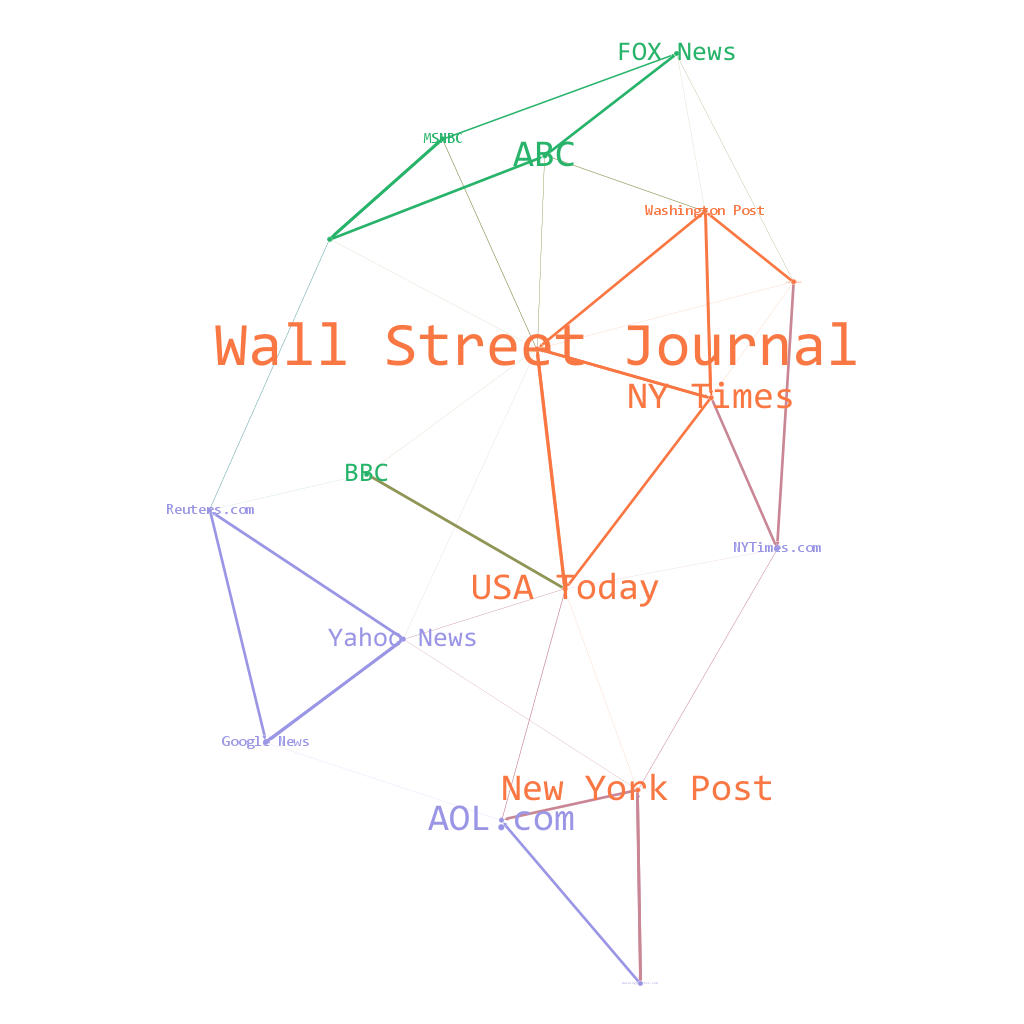

In [10]:
from IPython.display import Image
Image("new_network.png")